## 학습과정
### 1. Exploration
- policy는 큐함수에 대한 Boltzmann Exploration으로 탐험

### 2. Sample 저장
- 에이전트는 Boltzmann Exploration에 따라 [s, a, r, s']을 생성하고 reply mem에 append

### 3. random sampling으로 학습
- 미니배치 32
- 샘플로부터 target값과 prediction의 값을 구함
    - MSE : $(target - prediction)^2$
    - Target : $reward + \gamma \ max_{a'} q_{\theta} (s', a)$
    - Prediction : $q_{\theta}(s, a)$
- MSE error에 대한 gradient backpropagation설정

## Boltzmann Exploration
### About Exploration : http://ishuca.tistory.com/399

- Softmax를 이용해서 확률에 따라 탐험을 진행함
- tau(temperature parameter)는 숫자가 크다면 대부분이 비슷한 확률값을 갖게 됨
- 0에 가깝게 수렴한다면 가장 높은 값이 1에 가까운 값을 갖게됨

$$P_t(a) = \frac{\text{exp} \big( q_t(a) \big / \tau \big)}{\sum_{i=0}^n \text{exp} \big( q_t(i) \big/ \tau \big)}$$

### 1. Import Libs

In [1]:
import os
import numpy as np
import random
import gym
from matplotlib import pyplot as plt
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

plt.style.use('ggplot')
np.random.seed(123)
EPISODES = 300

Using TensorFlow backend.


### 2. Define Agent & Model
- Boltzmann Exploration 설정

In [2]:
plt.style.use('ggplot')
np.random.seed(123)
EPISODES = 300

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False # True
        
        ## tau설정
        self.tau = 1.0
        self.tau_min = 0.1
        self.t_step = (1 - self.tau_min) / 5000
        
        # state, action 사이즈 설정
        self.state_size = state_size
        self.action_size = action_size
        
        self.learning_rate = 0.001
        self.discount_factor = 0.99
        
        """ epsilon-greedy
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        """
        
        self.batch_size = 64
        self.train_start = 1000
        
        # 리플라이 메모리 설정
        self.memory = deque(maxlen=2000)
        
        # 모델과 타겟 모델 생성
        self.model = self.build_model()
        self.target_model = self.build_model()
        
        # 타겟모델 초기화
        self.update_target_model()
        
        if self.load_model:
            self.model.load_weights('./save_graph/carpole_dqn_boltzmann_trained.h5')
        
    # 스텝마다 지속적인 학습
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim = self.state_size, activation='relu', 
                       kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu',
                       kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                       kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    # 에피소드가 끝나면 한번 target_model을 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    # 볼츠만으로 행동을 선택
    # softmax형태로 행동을 선택함
    def get_action(self, state):
        q_value = self.model.predict(state)
        prob = self.softmax(q_value[0], self.tau)
        return np.random.choice(self.action_size, 1, p=prob)[0]
        
    # 리플라이 메모리
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def train_model(self):
        if self.tau > self.tau_min:
            self.tau -= self.t_step
            
        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)
        
        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []
    
        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])
    
        # 현재 상태에 대한 모델의 큐함수
        # 다음 상태에 대한 타깃 모델의 큐함수
        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)
    
        # 벨만 최적 방정식 -> DQN
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))
            
        self.model.fit(states, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    @staticmethod
    def softmax(x, t):
        x = x / t
        c =np.max(x)
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x)
        out = exp_x / sum_exp_x
        return out

### 3. Training

[2018-05-07 23:10:14,314] Making new env: CartPole-v1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_6 (Den

episode: 77   score: 123.0   memory length: 2000   tau: 0.15796000000009108 global steps :  5677
episode: 78   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  6177
episode: 79   score: 230.0   memory length: 2000   tau: 0.09982000000008867 global steps :  6408
episode: 80   score: 378.0   memory length: 2000   tau: 0.09982000000008867 global steps :  6787
episode: 81   score: 154.0   memory length: 2000   tau: 0.09982000000008867 global steps :  6942
episode: 82   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  7442
episode: 83   score: 271.0   memory length: 2000   tau: 0.09982000000008867 global steps :  7714
episode: 84   score: 488.0   memory length: 2000   tau: 0.09982000000008867 global steps :  8203
episode: 85   score: 418.0   memory length: 2000   tau: 0.09982000000008867 global steps :  8622
episode: 86   score: 162.0   memory length: 2000   tau: 0.09982000000008867 global steps :  8785
episode: 87   score: 200.0   m

episode: 161   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  44215
episode: 162   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  44715
episode: 163   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  45215
episode: 164   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  45715
episode: 165   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  46215
episode: 166   score: 472.0   memory length: 2000   tau: 0.09982000000008867 global steps :  46688
episode: 167   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  47188
episode: 168   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  47688
episode: 169   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  48188
episode: 170   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  48688
episode: 1

episode: 244   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  81311
episode: 245   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  81811
episode: 246   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  82311
episode: 247   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  82811
episode: 248   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  83311
episode: 249   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  83811
episode: 250   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  84311
episode: 251   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  84811
episode: 252   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  85311
episode: 253   score: 500.0   memory length: 2000   tau: 0.09982000000008867 global steps :  85811
episode: 2

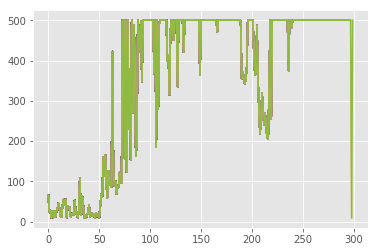

In [3]:
graph_path = os.path.join(os.getcwd(), 'save_graph')
model_path = os.path.join(os.getcwd(), 'save_model')

if not os.path.isdir(graph_path):
    os.mkdir(graph_path)    
if not os.path.isdir(model_path):
    os.mkdir(model_path)

# CartPole-v1 환경, 최대 타임스텝 수가 500
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# DQN 에이전트 생성
agent = DQNAgent(state_size, action_size)

scores, episodes = [], []
global_steps = 0

for e in range(EPISODES):
    done = False
    score = 0
    # env 초기화
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    
    
    while True:
        if agent.render:
            env.render()

        # 1. tau값을 이용한 softmax에 따른 사후분포에 따라서 step마다 행동을 선택함
        # 2. 학습 또한 step마다 수행함
        # 3. 에피소드마다 타깃 모델을 업데이트
            
        # 현재 상태로 행동을 선택
        action = agent.get_action(state)
        # 선택한 행동으로 환경에서 한 타임스텝 진행
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # 에피소드가 중간에 끝나면 -100 보상
        reward = reward if not done or score == 499 else -100

        # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
        agent.append_sample(state, action, reward, next_state, done)
        # 매 타임스텝마다 학습
        if len(agent.memory) >= agent.train_start:
            agent.train_model()

        score += reward
        state = next_state

        global_steps += 1

        if done:
            # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
            agent.update_target_model()
            
            score = score if score == 500 else score + 100
            # 에피소드마다 학습 결과 출력
            scores.append(score)
            episodes.append(e)
            plt.plot(episodes, scores)
            plt.savefig("./save_graph/cartpole_dqn_boltzmann.png")
            print("episode:", e, "  score:", score, "  memory length:", 
                  len(agent.memory), "  tau:", agent.tau, "global steps : ", global_steps)
            
            # 이전 10개 에피소드의 점수 평균이 490보다 크면 학습 중단

            if np.mean(scores[-min(10, len(scores)):]) > 490:
                agent.model.save_weights("./save_model/cartpole_dqn_boltzmann.h5")
                agent.render = True
                
            else:
                agent.render = False
            break
env.close()